# PSO - 0/1 Knapsack problem
Source: https://www.programmersought.com/article/18927400398/

In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from time import *
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def init_x(n, d):
    """
    :param n: total number of particles
         :param d: Number of particle genes (dimension)
         :return: randomly generated population (two-dimensional list)
    """
    population = []
    for i in range(n):
        gene = []
        for j in range(d):
            a = np.random.randint(0, 2)
            gene.append(a)
        population.append(gene)
    return population


def init_v(n, d, V_max, V_min):
    """
         :param n: total number of particles
         :param d: Number of particle genes (dimension)
         :return: randomly generated population (two-dimensional list)
    """
    v = []
    for i in range (n):
        vi = []
        for j in range (d):
            a = random.random() * (V_max - V_min) + V_min
            vi.append(a)
        v.append(vi)
    return v


#change to prevent copying
def fitness2(p, n, d, features, labels):

    selected = []
    accuracy = []

    #[i.value for i in train_test_split...]
    X_train, X_test, Y_train, Y_test = [i.values for i in train_test_split(features, labels, test_size = 0.3, random_state = 1)]

    for i in range(n):
        features = [i for i,val in enumerate(p[i]) if val==1]

        if len(features)>0:
            X = X_train[:, features]  # select the features
            test = X_test[:, features]

            #
            mlp = MLPClassifier(max_iter = 400, random_state = 1)
            mlp.fit(X, Y_train)
            pred = mlp.predict(test)
            acc_score = accuracy_score(Y_test, pred)

        else:
            acc_score = -1


        selected.append(features)
        accuracy.append(acc_score)

    return selected, accuracy



def fitness(p, n, d, w, w_max, v, afa):
    """
         :param p: particle swarm
         :param n: the number of particles in the group
         :param d: particle dimension
         :param w: item weight list
         :param w_max: Maximum backpack capacity
         :param v: the value list of the item
         :param afa: penalty coefficient
         :return: pbest fitness list of each particle
         :return: fitweight the weight of each particle
         tips: If the total weight of the item is greater than the maximum capacity of the backpack, a penalty coefficient is introduced
    """
    fitvalue = []
    fitweight = []
    for i in range (n):
        a = 0  # Weight of each particle
        b = 0  # The value of each particle (fitness)
        for j in range(d):
            if p[i][j] == 1:
                a += w[j]
                b += v[j]
        if a > w_max:
            b = 0
            # b = b + afa * (w_max-a) # overweight
        fitvalue.append(b)
        fitweight.append(a)
    return fitvalue, fitweight


def update_pbest(p, fitvalue, pbest, px, m):
    """
         Update individual optimal
         :param p: current population
         :param fitvalue: current fitness of each particle
         :param pbest: Individual optimal before update
         :param px: Individual optimal solution before update
         :param m: number of particles
         :return: updated individual optimal value, individual optimal solution
    """
    pb = pbest
    for i in range (m):
        if fitvalue[i] > pbest[i]:
            pbest[i] = fitvalue[i]
            px[i] = p[i]
    return pb, px


def update_gbest (p, pbest, gbest, g, m):
    """
         Update the global optimal solution
         :param p: particle swarm
         :param pbest: Individual fitness (individual best)
         :param gbest: global optimal
         :param g: global optimal solution
         :param m: number of particles
         :return: gbest global optimal, the global optimal solution corresponding to g
    """
    gb=gbest
    for i in range (m):
        if pbest[i] > gb:
            gb = pbest[i]
            g = p[i]
    return gb, g


def update_v(v, x, m, n, pbest, g, c1, c2, vmax, vmin):
    """
         refresh rate
         :param v: speed before update
         :param x: position before update
         :param m: number of particles
         :param n: particle dimension
         :param pbest: Individual optimal solution (two-dimensional list)
         :param g: global optimal solution (one-dimensional list)
         :param c1: acceleration factor
         :param c2: acceleration factor
         :param vmax: maximum speed
         :param vmin: minimum speed
         :return: Two-dimensional list of updated speeds
    """
    for i in range (m):
        a = random.random()
        b = random.random()
        for j in range (n):
            v[i][j]=v[i][j]+c1*a*(pbest[i][j]-x[i][j]) + c2*b*(g[j]-x[i][j])
            if v[i][j] < vmin:
                v[i][j] = vmin
            if v[i][j] > vmax:
                v[i][j] = vmax
    return v


def update_x(x, v, m, n):
    """
         Update x
         :param x: x before update
         :param v: updated v
         :param m: number of particles
         :param n: particle dimension
         :return: updated x
    """
    for i in range (m):
        for j in range(n):
            a = random.random()
            x[i][j] = 1/(1+math.exp(-v[i][j]))
            if x[i][j] > a:
                x[i][j] = 1
            else:
                x[i][j] = 0
    return x


In [2]:
import pandas as pd
#change directory of diabetes
from google.colab import drive
drive.mount('/content/drive')
file = "/content/drive/My Drive/diabetes.csv"
diabetes = pd.read_csv(file)

#change
features = diabetes.iloc[:, list(range(0, len(diabetes.columns)-1))]
labels = diabetes.iloc[:, -1]

Mounted at /content/drive


In [3]:
# main()
begin_time = time()
N = 25  # Number of group particles
D = features.shape[1]  # Particle dimension
T = 10  # The maximum number of iterations
c1 = 1.5  # Learning factor 1
c2 = 1.5  # Learning factor 2
V_max = 10  # Maximum speed
V_min = -10  # Speed ​​minimum


In [4]:
afa = 10  # Punishment factor
item = []  # Used to record the global optimal value of each iteration
itemg = []  # Used to record the global optimal solution of each iteration
x = init_x(N, D)  # Initialize x
v = init_v(N, D, V_max, V_min)  # Initialize v

In [5]:
#fv, fw = fitness(x, N, D, Weight, Weight_max, Value, afa)  # Calculate the fitness of the first iteration
fv, accuracy = fitness2(x, N, D, features, labels)

pb, px = accuracy, x  # Since it is the first iteration, the best individual is the current value
gb, g = update_gbest(x, pb, 0, [], N)  # In the same way, look for the global optimum of the first generation
item.append(gb)  # item list records the global optimum of each iteration
itemg.append(g)
v = update_v(v, x, N, D, px, g, c1, c2, V_max, V_min)  # Update the speed of the next generation
x = update_x(x, v, N, D)  # Update the position of the next generation

0.7922077922077922


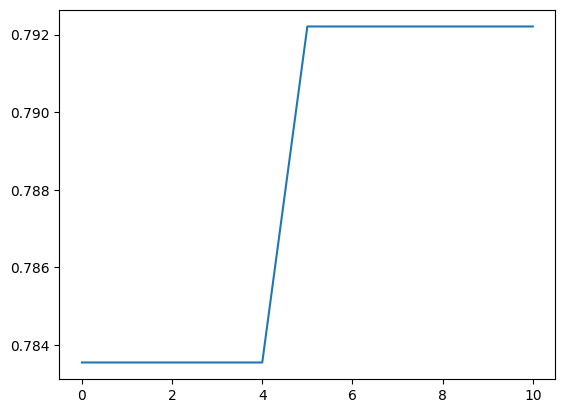

The particle swarm algorithm calculation time is: 165.92582821846008


In [6]:
for i in range(T):
    fv, accuracy = fitness2(x, N, D, features, labels)
    #print(accuracy)
    pb, px = update_pbest(x, accuracy, pb, px, N)
    gb, g = update_gbest(x, pb, gb, g, N)
    item.append(gb)
    itemg.append(g)
    v = update_v(v, x, N, D, px, g, c1, c2, V_max, V_min)
    x = update_x(x, v, N, D)

print(gb)
plt.plot(item)
plt.show()
end_time = time()
run_time = end_time - begin_time
print('The particle swarm algorithm calculation time is:', run_time)


### 4: different particle initialization

In [7]:
best_acc = {}
best_feat = {}

for N in range(5, 100, 5):
    begin_time = time()
    D = features.shape[1]  # Particle dimension
    T = 10  # The maximum number of iterations
    c1 = 1.5  # Learning factor 1
    c2 = 1.5  # Learning factor 2
    V_max = 10  # Maximum speed
    V_min = -10  # Speed ​​minimum

    afa = 10  # Punishment factor
    item = []  # Used to record the global optimal value of each iteration
    itemg = []  # Used to record the global optimal solution of each iteration
    x = init_x(N, D)  # Initialize x
    v = init_v(N, D, V_max, V_min)  # Initialize v

    fv, accuracy = fitness2(x, N, D, features, labels)
    pb, px = accuracy, x  # Since it is the first iteration, the best individual is the current value
    gb, g = update_gbest(x, pb, 0, [], N)  # In the same way, look for the global optimum of the first generation
    item.append(gb)  # item list records the global optimum of each iteration
    itemg.append(g)
    v = update_v(v, x, N, D, px, g, c1, c2, V_max, V_min)  # Update the speed of the next generation
    x = update_x(x, v, N, D)  # Update the position of the next generation

    for i in range(T):
        fv, accuracy = fitness2(x, N, D, features, labels)
        pb, px = update_pbest(x, accuracy, pb, px, N)
        gb, g = update_gbest(x, pb, gb, g, N)
        item.append(gb)
        itemg.append(g)
        v = update_v(v, x, N, D, px, g, c1, c2, V_max, V_min)
        x = update_x(x, v, N, D)

    end_time = time()
    runTime = end_time - begin_time
    best_acc[N] = item[-1]
    best_feat[N] = itemg[-1]

    print("%d: run time is: %d seconds" %(N, runTime))
    print("\tbest accuracty is ", float(best_acc[N]))

0.7662337662337663
5: run time is: 34 seconds	best accuracty is 0
0.7922077922077922
10: run time is: 71 seconds	best accuracty is 0
0.7922077922077922
15: run time is: 116 seconds	best accuracty is 0
0.7835497835497836
20: run time is: 134 seconds	best accuracty is 0
0.7835497835497836
25: run time is: 160 seconds	best accuracty is 0
0.7922077922077922
30: run time is: 168 seconds	best accuracty is 0
0.7922077922077922
35: run time is: 242 seconds	best accuracty is 0
0.7922077922077922
40: run time is: 339 seconds	best accuracty is 0
0.7922077922077922
45: run time is: 298 seconds	best accuracty is 0
0.7922077922077922
50: run time is: 330 seconds	best accuracty is 0
0.7922077922077922
55: run time is: 386 seconds	best accuracty is 0
0.7922077922077922
60: run time is: 385 seconds	best accuracty is 0
0.7922077922077922
65: run time is: 457 seconds	best accuracty is 0
0.7922077922077922
70: run time is: 522 seconds	best accuracty is 0
0.7922077922077922
75: run time is: 498 seconds	bes

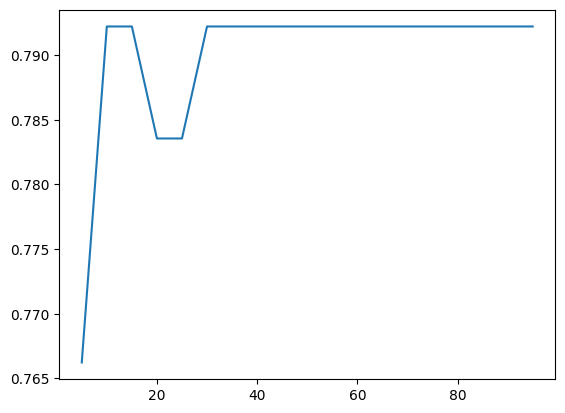

In [8]:
x_vals = best_acc.keys()
y_vals = best_acc.values()
plt.plot(x_vals, y_vals)

### 5. Modify hyperparameter values

In [ ]:
best_acc = {}
best_feat = {}

for T in range(5, 100, 5):
    begin_time = time()
    D = features.shape[1]  # Particle dimension
    N = 15  # The maximum number of iterations
    c1 = 1.5  # Learning factor 1
    c2 = 1.5  # Learning factor 2
    V_max = 10  # Maximum speed
    V_min = -10  # Speed ​​minimum

    afa = 10  # Punishment factor
    item = []  # Used to record the global optimal value of each iteration
    itemg = []  # Used to record the global optimal solution of each iteration
    x = init_x(N, D)  # Initialize x
    v = init_v(N, D, V_max, V_min)  # Initialize v

    fv, accuracy = fitness2(x, N, D, features, labels)
    pb, px = accuracy, x  # Since it is the first iteration, the best individual is the current value
    gb, g = update_gbest(x, pb, 0, [], N)  # In the same way, look for the global optimum of the first generation
    item.append(gb)  # item list records the global optimum of each iteration
    itemg.append(g)
    v = update_v(v, x, N, D, px, g, c1, c2, V_max, V_min)  # Update the speed of the next generation
    x = update_x(x, v, N, D)  # Update the position of the next generation

    for i in range(T):
        fv, accuracy = fitness2(x, N, D, features, labels)
        pb, px = update_pbest(x, accuracy, pb, px, N)
        gb, g = update_gbest(x, pb, gb, g, N)
        item.append(gb)
        itemg.append(g)
        v = update_v(v, x, N, D, px, g, c1, c2, V_max, V_min)
        x = update_x(x, v, N, D)

    end_time = time()
    runTime = end_time - begin_time
    best_acc[T] = item[-1]
    best_feat[T] = itemg[-1]

    print("%d: run time is: %d seconds" %(T, runTime))
    print("\tbest accuracty is ", float(best_acc[T]))


5: run time is: 55 seconds	best accuracty is 0
10: run time is: 111 seconds	best accuracty is 0
15: run time is: 145 seconds	best accuracty is 0
20: run time is: 216 seconds	best accuracty is 0
25: run time is: 223 seconds	best accuracty is 0
30: run time is: 372 seconds	best accuracty is 0
35: run time is: 422 seconds	best accuracty is 0
40: run time is: 441 seconds	best accuracty is 0
45: run time is: 552 seconds	best accuracty is 0
50: run time is: 458 seconds	best accuracty is 0
55: run time is: 508 seconds	best accuracty is 0
60: run time is: 468 seconds	best accuracty is 0


In [ ]:
x_vals = best_acc.keys()
y_vals = best_acc.values()
plt.plot(x_vals, y_vals)